In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats

import pynbody as pb

import glob
import os
import re
from tqdm.notebook import tqdm

# Glob + Regex to get the paths

In [4]:
all_paths = glob.glob('/mnt/storage/_data/nihao/nihao_classic/g*/0*/*.*.*')
# Regular expression to match files that end with 5 numbers and don't have a dot at the end

regex = r'^.*\d{5}$' #all the snapshots


# Filter the list of files
paths = [path for path in all_paths if re.match(regex, path)]


# Pynbody extraction 

In [5]:
def extract_parameter_dictionary(path='str'):
    """
    Extracts the parameters and the observable of the simulation snapshot from its path. Two dictionaries are returned, one with the parameters and another with the observables.
    The parameters that are extracted are: star_mass, gas_mass, dm_mass, infall_time, redshift, a, chemical_mean and chemical_std.
    The observables that are extracted are: [Fe/H], [O/Fe].


    Parameters
    ----------
    path : str 
        Path to the simulation snapshot
    
    Returns
    -------
    parameters : dict
        parameters['star_mass'] : float
            Total mass of the formed stars in the snapshot
        parameters['gas_mass'] : float
            Total mass of the gas in the snapshot
        parameters['dm_mass'] : float
            Total mass of the dark matter in the snapshot
        parameters['infall_time'] : float
            Time at which the snapshot was taken in Gyr
        parameters['redshift'] : float
            Redshift at which the snapshot was taken
        parameters['a'] : float
            Scale factor at which the snapshot was taken
        parameters['chemical_mean'] : np.array
            Array with the mean of metals, FeMassFrac and OxMassFrac in the snapshot
        parameters['chemical_std'] : np.array
            Array with the standard deviation of metals, FeMassFrac and OxMassFrac in the snapshot
    observables : dict
        observables['feh'] : np.array
            Array with the [Fe/H] of the formed stars in the snapshot
        observables['ofe'] : np.array
            Array with the [O/Fe] of the formed stars in the snapshot
    """
    sim = pb.load(path)
    sim.physical_units()
    h = sim.halos(write_fpos=False)
    pb.analysis.angmom.faceon(h[1])
    if len(sim.s['mass']) > 0:
        parameters = {'star_mass': sim.s['mass'].sum(),
                'gas_mass': sim.g['mass'].sum(),
                'dm_mass': sim.dm['mass'].sum(),
                'infall_time': sim.properties['time'].in_units('Gyr'),
                'redshift': sim.properties['z'],
                'a':sim.properties['a'], 
                'chemical_mean':np.array([sim.s['metals'].mean(), sim.s['FeMassFrac'].mean(), sim.s['OxMassFrac'].mean()]),
                'chemical_std':np.array([sim.s['metals'].std(), sim.s['FeMassFrac'].std(), sim.s['OxMassFrac'].std()])}
        feh = sim.s['feh']
        ofe = sim.s['ofe']
        observables = {'feh': feh,
                     'ofe': ofe}
        return parameters, observables
    else:
        print('Not formed stars yet')

pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


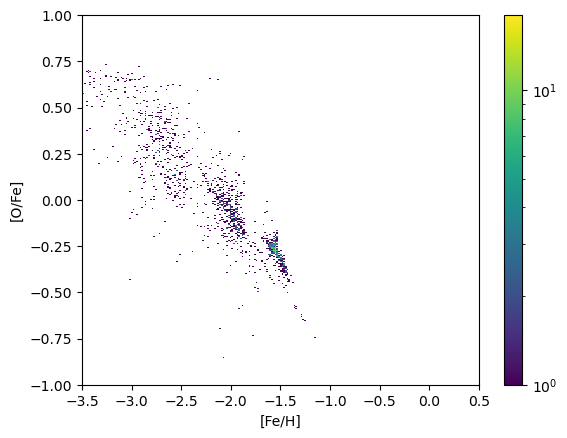

In [7]:
params, observable   = extract_parameter_dictionary(paths[191])

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.hist2d(observable['feh'], observable['ofe'], bins=(2000, 2000), norm=colors.LogNorm());
fig.colorbar(cax[3], ax=ax)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.set_xlim(-3.5, 0.5) 
ax.set_ylim(-1, 1.0);

In [9]:
def extract_parameter_array(path='str', path_parameters='str', path_observables='str') -> None:
    """
    Extract the parameters and observables from the path. Checks all the possible errors and if one is found it is saved as an 'error_file'.  
    If no stars were formed in the snapshot, the function dosen't save any file.
    Two .npz files are returned, one with the parameters and another with the observables.
    In order to load the parameters values use the common way of accessing numpy array in .npz file, for example: np.load('file.npz')['star_mass'].
    The parameters that are extracted are: star_mass, gas_mass, dm_mass, infall_time, redshift, a, chemical_mean and chemical_std.
    The observables that are extracted are: [Fe/H], [O/Fe], refered to as 'feh' and 'ofe'.

    Parameters
    ----------
    path : str 
        Path to the simulation snapshot. The path should end with 'simulation_name.snapshot_number' and it is used to create the name of the .npz files.
    path_parameters : str
        Path to the folder where the parameters file will be saved
    path_observables : str
        Path to the folder where the observables file will be saved
    
    Returns
    -------
    parameters : .npz array
        The file is save in the folder '/path_parametrs/name_file_parameters.npz' and contains the following parameters:
    
        parameters['star_mass'] : float
            Total mass of the formed stars in the snapshot
        parameters['gas_mass'] : float
            Total mass of the gas in the snapshot
        parameters['dm_mass'] : float
            Total mass of the dark matter in the snapshot
        parameters['infall_time'] : float
            Time at which the snapshot was taken in Gyr
        parameters['redshift'] : float
            Redshift at which the snapshot was taken
        parameters['a'] : float
            Scale factor at which the snapshot was taken
        parameters['chemical_mean'] : np.array
            Array with the mean of metals, FeMassFrac and OxMassFrac in the snapshot
        parameters['chemical_std'] : np.array
            Array with the standard deviation of metals, FeMassFrac and OxMassFrac in the snapshot

    observables : .npz array
        The file is save in the folder '/path_observables/name_file_observables.npz' and contains the following parameters:

        observables['feh'] : np.array
            Array with the [Fe/H] of the formed stars in the snapshot
        observables['ofe'] : np.array
            Array with the [O/Fe] of the formed stars in the snapshot
    """
    

    #extract the name of the simulation+snapshot_number to create the name of the files to save
    regex = r'[^/]+$'
    name_file = re.search(regex, path).group()
    
    try:
        #check if the file can be loaded
        sim = pb.load(path)
        sim.physical_units()
    except:
        np.savez(file=path_parameters + name_file + '_load_error.npz', emppty=np.array([0]))
        np.savez(file=path_observables + name_file + '_load_error.npz', emppty=np.array([0]))
    else:
        try:
            #check if the halos can be loaded
            h = sim.halos(write_fpos=False)
        except:
            np.savez(file=path_parameters + name_file + '_halos_error.npz', emppty=np.array([0]))
            np.savez(file=path_observables + name_file + '_halos_error.npz', emppty=np.array([0]))
        else:
            try:
                #check if the frame of reference can be set such that the disk is face on
                pb.analysis.angmom.faceon(h[1])
            except:
                np.savez(file=path_parameters + name_file + '_faceon_error.npz', emppty=np.array([0]))
                np.savez(file=path_observables + name_file + '_faceon_error.npz', emppty=np.array([0]))
            else:
                #check if the simualtion has formed stars
                if len(sim.s['mass']) > 0:
                    
                    name_parameter_file = path_parameters + name_file + '_parameters.npz'
                    name_observable_file = path_observables + name_file + '_observables.npz'

                    #PARAMETERS
                    star_mass = sim.s['mass'].sum() #in Msol
                    gas_mass = sim.g['mass'].sum()  #in Msol
                    dm_mass = sim.dm['mass'].sum()  #in Msol
                    infall_time = sim.properties['time'].in_units('Gyr')
                    redshift = sim.properties['z']
                    a = sim.properties['a']
                    try: 
                        #check if the metals, Iron mass fraction and Oxygen mass fraction mean and std can be extracted
                        chemical_mean = np.array([sim.s['metals'].mean(), sim.s['FeMassFrac'].mean(), sim.s['OxMassFrac'].mean()])
                        chemical_std = np.array([sim.s['metals'].std(), sim.s['FeMassFrac'].std(), sim.s['OxMassFrac'].std()])
                    except:
                        np.savez(file=path_parameters + name_file + '_ZMassFracc_error.npz', emppty=np.array([0]))
                        np.savez(file=path_observables + name_file + '_ZMassFracc_error.npz', emppty=np.array([0]))
                    else:
                        #OBSERVABLE
                        try:
                            #check if the [Fe/H] and [O/Fe] can be extracted
                            feh = sim.s['feh']
                            ofe = sim.s['ofe']
                        except:
                            np.savez(file=path_parameters + name_file + '_FeO_error.npz', emppty=np.array([0]))
                            np.savez(file=path_observables + name_file + '_FeO_error.npz', emppty=np.array([0]))
                        else:
                            np.savez(file=name_parameter_file, star_mass=star_mass, gas_mass=gas_mass, dm_mass=dm_mass, infall_time=infall_time, redshift=redshift, a=a, chemical_mean=chemical_mean, chemical_std=chemical_std)
                            np.savez(file=name_observable_file, feh=feh, ofe=ofe)

                else:
                    print('Not formed stars yet')

In [11]:
for path in tqdm(paths[:2]):
    print(path)
    extract_parameter_array(path, path_parameters='../../data/parameters/', path_observables='../../data/observables/')

  0%|          | 0/2 [00:00<?, ?it/s]

/mnt/storage/_data/nihao/nihao_classic/g1.05e11/00016/g1.05e11.00016
Not formed stars yet
/mnt/storage/_data/nihao/nihao_classic/g1.05e11/00032/g1.05e11.00032


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


# Load the parameters and observables

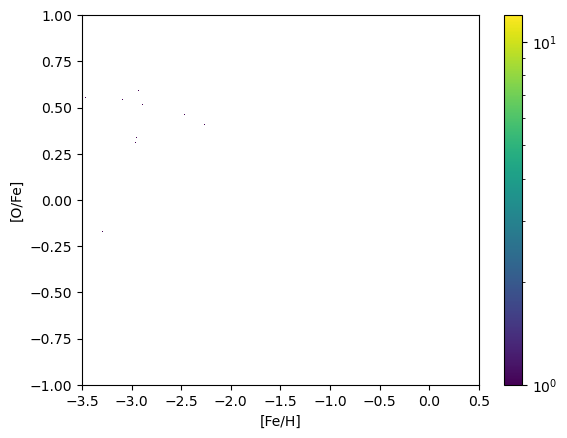

In [47]:
path_2parameters = sorted(os.listdir('../../data/parameters/'))
path_2observables = sorted(os.listdir('../../data/observables/'))

regex = r'^(?!.*error)'

# Filter the lists of paths
path_2parameters = [path for path in path_2parameters if re.search(regex, path)]
path_2observables = [path for path in path_2observables if re.search(regex, path)]

n = 189
parameters = np.load('../../data/parameters/' + path_2parameters[n])
observables = np.load('../../data/observables/' + path_2observables[n])
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.hist2d(observables['feh'], observables['ofe'], bins=(2000, 2000), norm=colors.LogNorm());
fig.colorbar(cax[3], ax=ax)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.set_xlim(-3.5, 0.5) 
ax.set_ylim(-1, 1.0);